In [1]:
import sys
sys.path

['/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/home/rpal/.local/lib/python3.10/site-packages',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/dlib-19.16.0-py3.10-linux-x86_64.egg',
 '/usr/lib/python3/dist-packages']

In [2]:
sys.path.append("../../quMCMC")  # Adjust the path as necessary #this is a bit strange isn't it?

In [3]:
import qumcmc

In [4]:
## import essential modules 
from qumcmc.basic_utils import *
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import classical_mcmc
from qumcmc.quantum_mcmc_routines import quantum_enhanced_mcmc # Manuel's code
from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics
from qumcmc.prob_dist import DiscreteProbabilityDistribution

### Case of BAS dataset. final plots

In [5]:
gridsize=3
bas= bas_dataset(grid_size=gridsize)
bas.dataset.sort()

     MODEL : ising model BAS 9X9 |  beta : 1.5
Num Most Probable States : 12
Entropy : 3.5849625001146053
---------------------------------------------


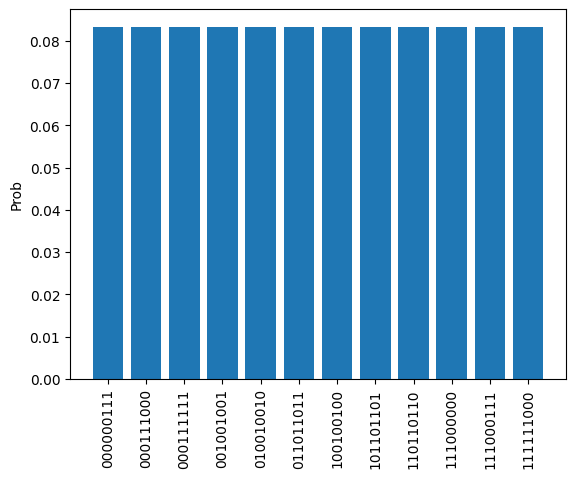

In [6]:
# consider only the bars dataset and create the weight matrix for them and create the ising model
wt = hebbing_learning(bas.bas_dict["bars"]+ bas.bas_dict["stripes"])
n_spins=gridsize*gridsize
shape_of_J=(n_spins,n_spins)
J=-1*wt
h=np.zeros(n_spins)
model=IsingEnergyFunction(J,h,name=f'ising model BAS {n_spins}X{n_spins}')

beta=1.5
## run exact sampling over all possible configurations 
exact_sampled_model = Exact_Sampling(model, beta)

## get distribution from the model
bpd= DiscreteProbabilityDistribution(exact_sampled_model.boltzmann_pd)
exact_sampled_model.sampling_summary()


In [7]:
# bas.bas_dict["stripes"]

In [72]:
from typing import Union
from qumcmc.basic_utils import plot_with_error_band

import matplotlib.colors as mcolors


def plot_proposal_and_acceptance_prob(input,list_of_list_running_kl,labels,title = None,
                                    gridsize=3,steps=50000, 
                                    std_dev_multiplicative_factor=0.5,
                                    dist: Union[str, list]=0):
    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    if title : plt.suptitle(title)
    (ax1, ax2, ax3) = axes

    num_plots=len(input)
    ### hamming plot
    for i in range(0,num_plots):
        ax1.plot(np.arange(gridsize**2+1), [r["total"]/steps for r in input[i]["hamming"].values()],
                                                    marker="o", label=labels[i])
        #ax1.set_yscale("log")
        ax1.set_ylabel("Proposal Probability")
        ax1.set_xlabel("Hamming Distance")
    ax1.legend(fontsize=8)

    # ### acceptance probability
    # marker_formats = ['o', 's', '^', 'D', 'v']
    # # list of colors
    # colors = list(mcolors.TABLEAU_COLORS.keys())[:num_plots]
    # for i in range(0, num_plots):
    #     ax2.stem(np.arange(gridsize**2+1)+dist[i], [r["accepted"]/r["total"] if r["total"] >0 
    #                                         else 0 for r in input[i]["hamming"].values() ], 
    #                                         label=labels[i],markerfmt=marker_formats[i],
    #                                         linefmt=f'C{i}-') ### remove.bar
        
    #     # ax2.bar(np.arange(gridsize**2+1)+dist[i], [r["accepted"]/r["total"] if r["total"] >0 
    #     #                                     else 0 for r in input[i]["hamming"].values() ], 
    #     #                                     label=labels[i]) ### remove.bar
    # # plt.yscale("log")
    # ax2.set_ylabel("Aceptance Probability")
    # ax2.set_xlabel("Hamming Distance")
    # ax2.set_xticks([0,1,2,3,4,5,6,7,8,9])
    # ax2.legend(fontsize=7.5)

    ### KL plot
    #xval=np.arange(0,len(list_of_list_running_kl[0][0]))
    #print("len xval is:",len(xval))
    for i in range(0,num_plots):
        xval=np.arange(0,len(list_of_list_running_kl[i][0]))
        curve_mean_value= np.mean(list_of_list_running_kl[i],axis=0)
        standard_dev_band=np.std(list_of_list_running_kl[i],axis=0)
        ax3.plot(xval, curve_mean_value, "-", label=labels[i])
        ax3.fill_between(xval, 
                            curve_mean_value-standard_dev_band*std_dev_multiplicative_factor,
                            curve_mean_value+standard_dev_band*std_dev_multiplicative_factor,
                            alpha=0.5)
    ax3.set_yscale("log")
    ax3.set_ylabel("KL Divergence")
    ax3.set_xlabel("MCMC Iteration")
    ax3.legend(loc="upper right",fontsize=7.5)


In [9]:
### file to load
import os
import pickle

# Get the current working directory (PWD)
pwd = os.getcwd()

# Define the new folder name
new_folder_name = "results_with_new_code"

# Create the full path for the new folder
results_folder_location = os.path.join(pwd, new_folder_name)

results_folder_location

'/home/rpal/Documents/QBMS/quMCMC/final_results_notebooks/results_with_new_code'

In [45]:
### code to get list of running kl divergences
def list_of_running_kl(list_of_mcmc_chains, bpd):
    list_kl=[]
    for i in tqdm(range(0,len(list_of_mcmc_chains))):
        kl=calculate_running_kl_divergence(bpd,
                                            mcmc_chain=list_of_mcmc_chains[i],
                                            skip_steps=1)
        list_kl.append(kl)
    
    return list_kl

In [39]:
COH_MIXER_DATA = {}
for file in os.scandir('BAS-coherent-mixers'):
    mcr = float(file.name.split("=")[1].split(".pkl")[0])
    with open(file, 'rb') as f : COH_MIXER_DATA[mcr] = pickle.load(f)

INCOH_MIXER_DATA = {}
for file in os.scandir('BAS-incoherent-mixers'):
    mcr = float(file.name.split("=")[1].split(".pkl")[0])
    with open(file, 'rb') as f : INCOH_MIXER_DATA[mcr] = pickle.load(f)
    

In [42]:
COH_MIXER_DATA[0.402][np.random.randint(len(COH_MIXER_DATA[0.402]))]

MCMCChain()

In [46]:
TRAJPROC_COH = dict([(mcr, {}) for mcr in COH_MIXER_DATA.keys() ])
for mcr, data in COH_MIXER_DATA.items() :
    TRAJPROC_COH[mcr]['kldiv-var'] = list_of_running_kl( data, bpd= bpd)
    TRAJPROC_COH[mcr]['stat-var'] = get_trajectory_statistics(mcmc_chain= data[np.random.randint(len(data))], model= exact_sampled_model)
    

100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


In [47]:
TRAJPROC_INCOH = dict([(mcr, {}) for mcr in INCOH_MIXER_DATA.keys() ])
for mcr, data in INCOH_MIXER_DATA.items() :
    TRAJPROC_INCOH[mcr]['kldiv-var'] = list_of_running_kl( data, bpd= bpd)
    TRAJPROC_INCOH[mcr]['stat-var'] = get_trajectory_statistics(mcmc_chain= data[np.random.randint(len(data))], model= exact_sampled_model)
    

100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


In [67]:
len(np.linspace(0.1, -0.1, len(TRAJPROC_COH.keys()))) , len(TRAJPROC_COH.keys())

(6, 6)

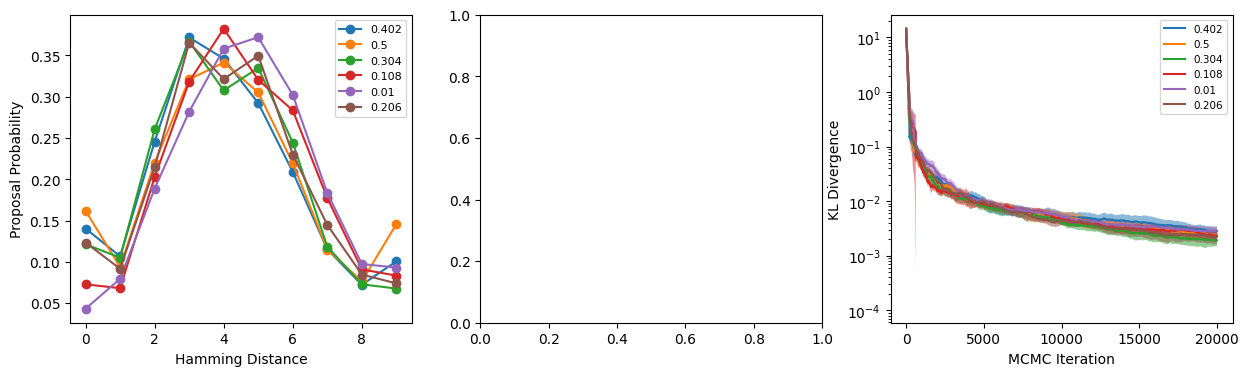

In [78]:
plot_proposal_and_acceptance_prob( input= [TRAJPROC_COH[mcr]['stat-var'] for mcr in TRAJPROC_COH.keys()],
                                   list_of_list_running_kl= [TRAJPROC_COH[mcr]['kldiv-var'] for mcr in TRAJPROC_COH.keys()],
                                    labels = [str(round(mcr, 3)) for mcr in TRAJPROC_COH.keys()],
                                      steps= 10000,
                                       dist= np.linspace(0.1, -0.1, len(TRAJPROC_COH.keys())) )
                                          

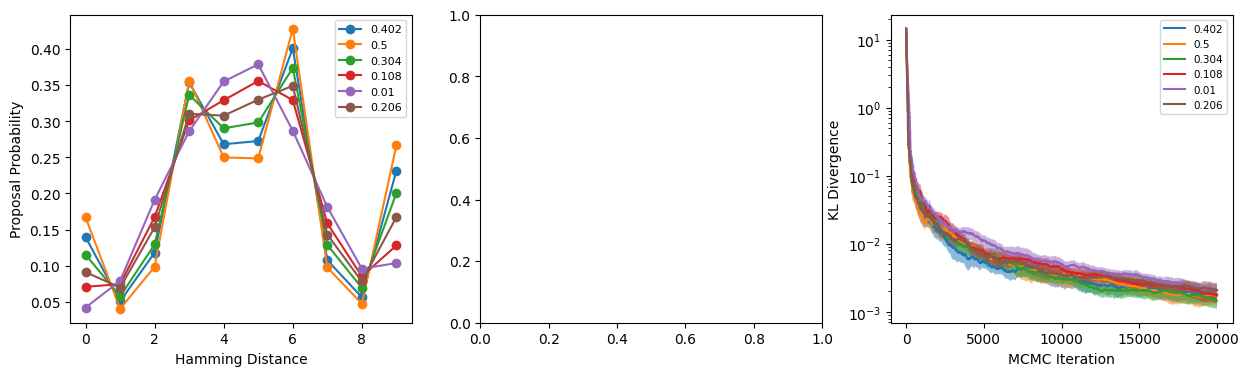

In [77]:
plot_proposal_and_acceptance_prob( input= [TRAJPROC_INCOH[mcr]['stat-var'] for mcr in TRAJPROC_INCOH.keys()],
                                   list_of_list_running_kl= [TRAJPROC_INCOH[mcr]['kldiv-var'] for mcr in TRAJPROC_INCOH.keys()],
                                    labels = [str(round(mcr, 3)) for mcr in TRAJPROC_INCOH.keys()],
                                      steps= 10000,
                                       dist=[-0.0910,0,0.0910] )
                                          

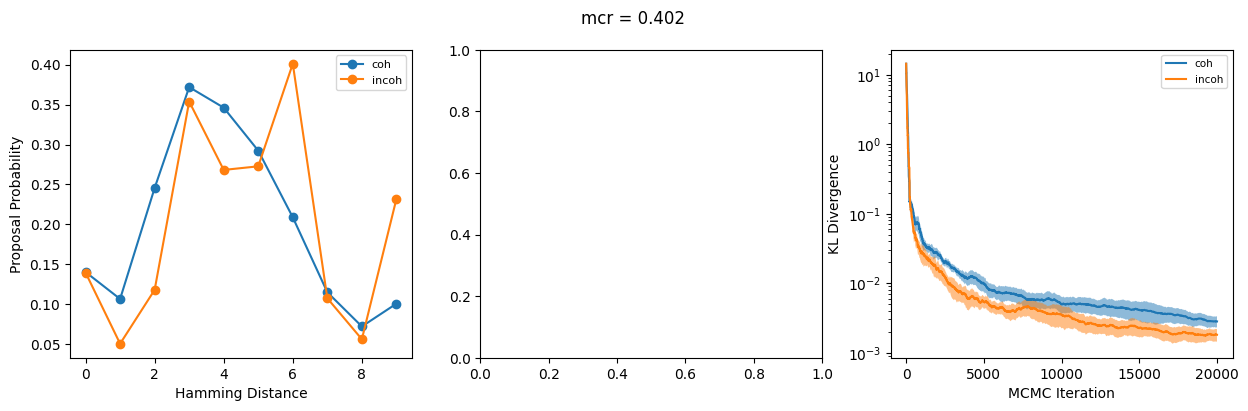

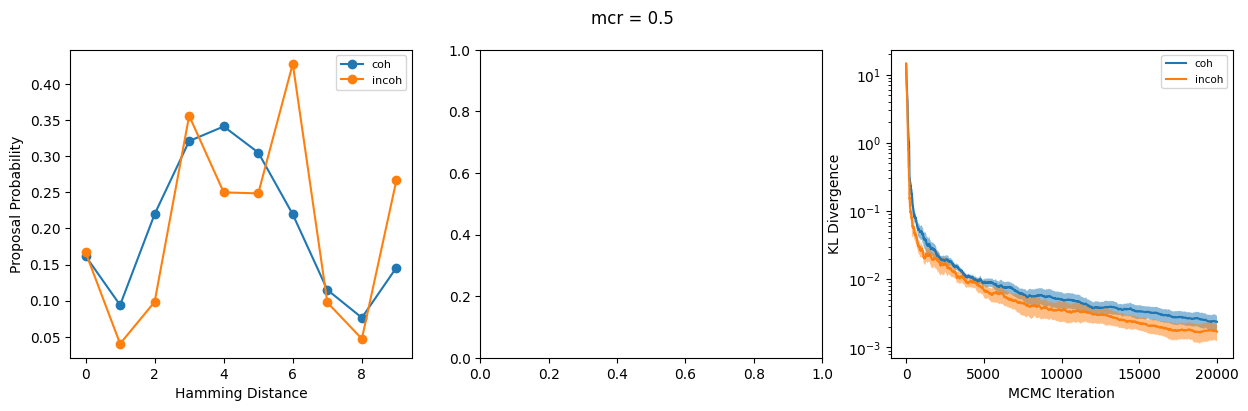

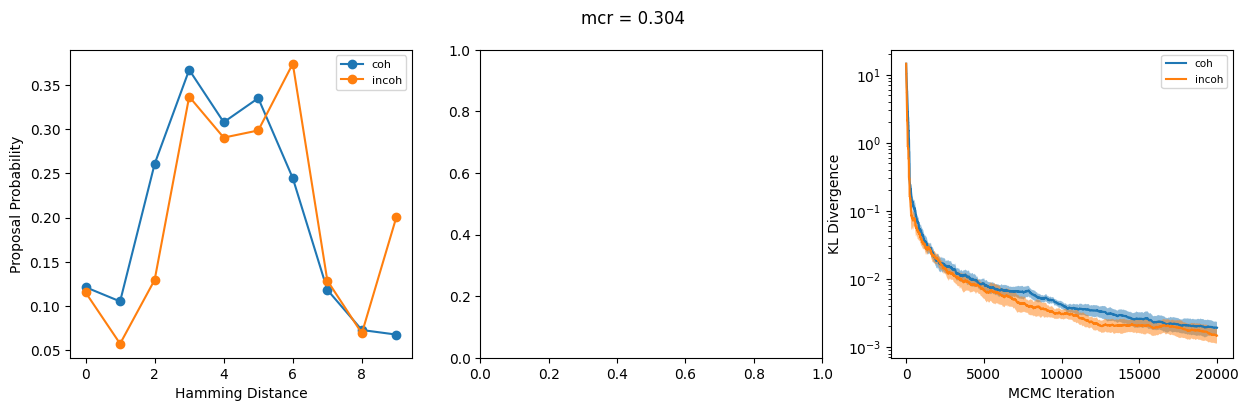

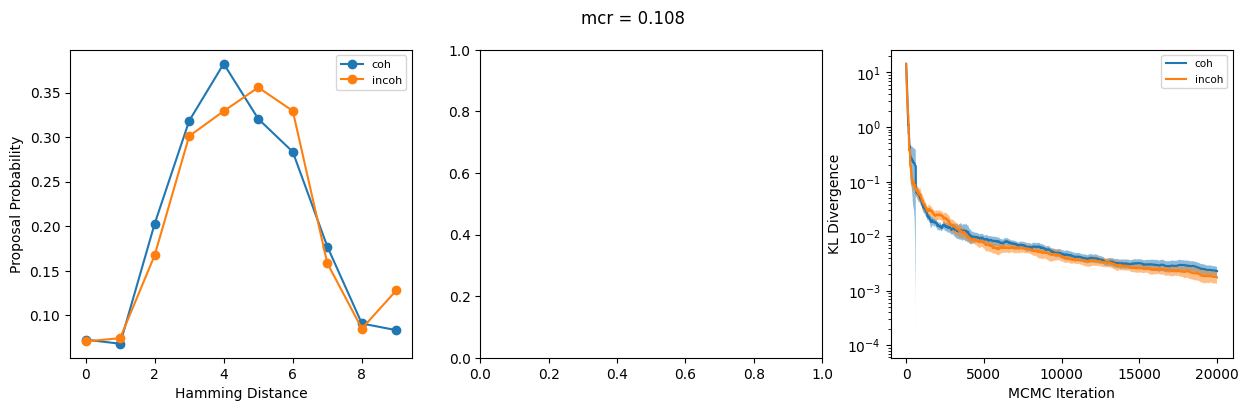

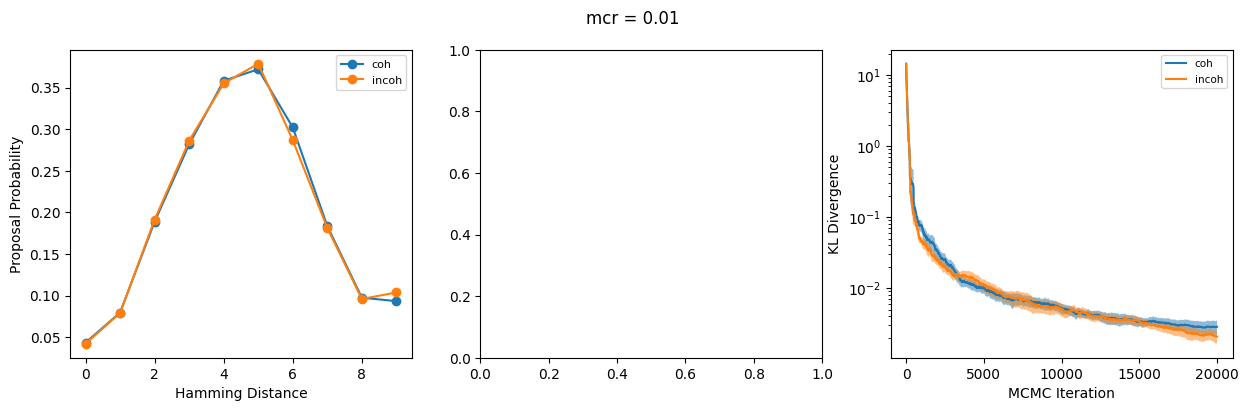

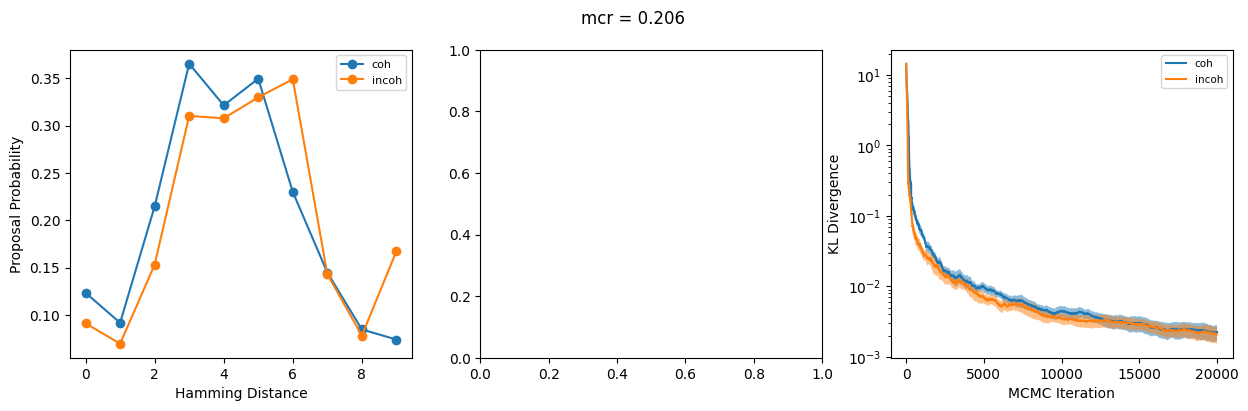

In [79]:
for mcr in TRAJPROC_INCOH.keys():
    #  print('mcr: ', mcr)
     plot_proposal_and_acceptance_prob(input= [TRAJPROC_COH[mcr]['stat-var'], TRAJPROC_INCOH[mcr]['stat-var'] ],
                                       list_of_list_running_kl= [TRAJPROC_COH[mcr]['kldiv-var'], TRAJPROC_INCOH[mcr]['kldiv-var'] ], 
                                        labels= ['coh', 'incoh'],
                                          title= 'mcr = ' + str(round(mcr, 3)),
                                            steps= 10000, 
                                              dist=[-0.0910,0,0.0910]
                                       )
    